In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
UC_Sampled = pd.read_csv('datasets/uncontrollable_sample.csv', index_col='id')
df_controllable_sampled = pd.read_csv('datasets/controllable_sampled.csv', index_col = 'id')
df_controllable_all = pd.read_csv('Faizan_scratch/Controllables/controllable_cleaned_features.csv', index_col='id')
df_uncontrollable_all = pd.read_csv('Faizan_scratch/uncontrollable_cleaned_features.csv', index_col='id')

df_all_features = df_controllable_all.merge(df_uncontrollable_all, left_index=True, right_index=True)
df_all_features = df_all_features.drop(columns=['host_is_superhost', 'Label_y'])
df_all_features = df_all_features.rename(columns={'Label_x':'Label'})

uncontrollable_columns = UC_Sampled.drop(columns='Label').columns
controllable_columns = df_controllable_sampled.drop(columns='Label').columns

In [3]:
from sklearn.model_selection import train_test_split, PredefinedSplit


X_trainval, X_test, Y_trainval, Y_test = train_test_split(df_all_features.drop('Label',1), 
                                                          df_all_features['Label'],
                                                         test_size = 0.2,
                                                         random_state = 42)


X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, 
                                                  Y_trainval, 
                                                  test_size = 0.25, # Corresponds to 20% of total data
                                                  random_state = 42)

# Use 'pds' as the cv parameter in GridSearchCV/RandomizedSearchCV:

split_index = [-1 if x in X_train.index else 0 for x in X_trainval.index]
pds = PredefinedSplit(test_fold = split_index)

In [5]:
# Split training/validation and test sets by feature categories

X_trainval_uc, X_trainval_c = X_trainval[uncontrollable_columns], X_trainval[controllable_columns]
X_test_uc, X_test_c = X_test[uncontrollable_columns], X_test[controllable_columns]

# For baseline models
X_train_uc, X_train_c = X_train[uncontrollable_columns], X_train[controllable_columns]
X_val_uc, X_val_c = X_val[uncontrollable_columns], X_val[controllable_columns]


In [6]:
from sklearn.preprocessing import StandardScaler

# Scale features for LR
# Note these will be used again for hyperparameter tuning, so need to scale:

scaler = StandardScaler()

X_train_uc = pd.DataFrame(scaler.fit_transform(X_train_uc), columns = uncontrollable_columns)
X_train_c = pd.DataFrame(scaler.fit_transform(X_train_c), columns = controllable_columns)

X_val_uc = pd.DataFrame(scaler.fit_transform(X_val_uc), columns = uncontrollable_columns)
X_val_c = pd.DataFrame(scaler.fit_transform(X_val_c), columns = controllable_columns)

X_trainval_uc = pd.DataFrame(scaler.fit_transform(X_trainval_uc), columns = uncontrollable_columns)
X_trainval_c = pd.DataFrame(scaler.fit_transform(X_trainval_c), columns = controllable_columns)

X_test_uc = pd.DataFrame(scaler.fit_transform(X_test_uc), columns = uncontrollable_columns)
X_test_c = pd.DataFrame(scaler.fit_transform(X_test_c), columns = controllable_columns)

## Final Bakeoff

### Uncontrollable

In [7]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm, linear_model, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [8]:
#Best models:

best_rf_uc = rf_uc_best = RandomForestClassifier(criterion='entropy',n_estimators=101
                                    ,min_samples_split=300, min_samples_leaf=1
                                    ,max_features=161)
best_gb_uc = GradientBoostingClassifier(learning_rate=0.025, max_depth=15,
                            max_features='sqrt', min_samples_leaf=0.034,
                            min_samples_split=0.08916666666666667,
                            n_estimators=2500)
best_dt_uc = DecisionTreeClassifier(criterion='entropy',
                       min_samples_leaf=0.0030204081632653063,
                       min_samples_split=0.03326530612244898)
best_svm_uc = svm.SVC(kernel = 'rbf', C = 25.402764157911143)
best_lr_uc = linear_model.LogisticRegression(C = 0.2520004993764092, penalty = 'l1', max_iter = 4000, solver = 'liblinear')


models = {'RF': best_rf_uc, 'GB' : best_gb_uc, 'DT' : best_dt_uc, 'SVM': best_svm_uc, 'LR': best_lr_uc}

In [9]:
for model in models:
    models[model].fit(X_train_uc, Y_train)

In [42]:
predictions_rf = best_rf_uc.predict_proba(X_val_uc)[:,1]
predictions_gb = best_gb_uc.predict_proba(X_val_uc)[:,1]
predictions_dt = best_dt_uc.predict_proba(X_val_uc)[:,1]
predictions_svm = best_svm_uc.decision_function(X_val_uc)
predictions_lr = best_lr_uc.predict_proba(X_val_uc)[:,1]

predictions = {'RF': predictions_rf, 'GB' : predictions_gb, 'DT' : predictions_dt, 'SVM': predictions_svm, 'LR': predictions_lr}

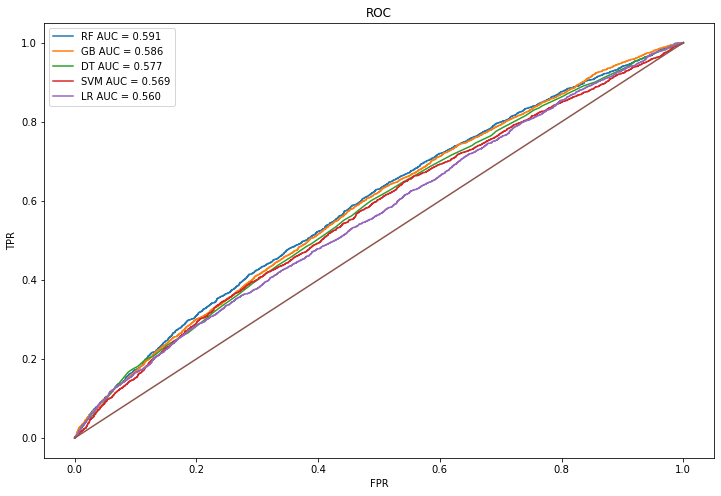

In [45]:
#Plot ROC curves of the two models

plt.figure(figsize=(12,8))

aucs = []
labels = []

for prediction in predictions:
    fpr, tpr, thresholds = metrics.roc_curve(Y_val, predictions[prediction])
    auc = metrics.auc(fpr,tpr)
    aucs.append(auc)
    labels.append(prediction)
    label = prediction + " AUC = %.3f"%auc
    plt.plot(fpr,tpr,label = label)
    

#Plot 45 degree line
plt.plot([0,1],[0,1])

plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

plt.show()

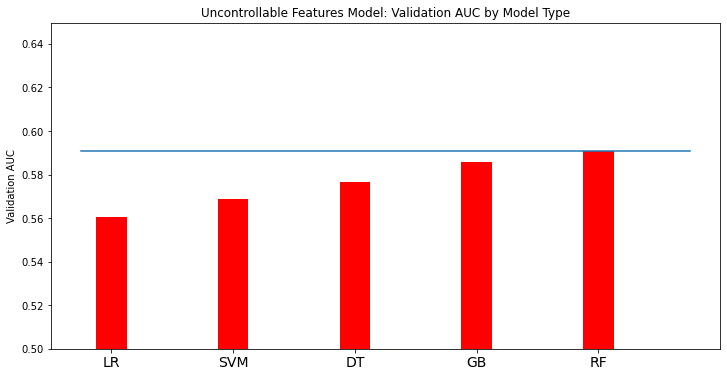

In [46]:
results = np.array(aucs)
labs = np.array(labels)[results.argsort()]
results.sort()

fig = plt.figure(facecolor = 'w', figsize = (12, 6))
ax = plt.subplot(111)

width = 0.25
ind = np.arange(5)
rec = ax.bar(ind + width, results, width, color='r')

ax.set_xticks(ind + width)
ax.set_xticklabels(labs, size = 14)
ax.set_ylim([0.5, max(results)*1.1])

plt.plot(np.arange(6), max(results) * np.ones(6))
plt.ylabel('Validation AUC')
plt.title('Uncontrollable Features Model: Validation AUC by Model Type')
plt.show()

### Controllable

In [13]:
best_rf_c = RandomForestClassifier(criterion='entropy',max_features=10,oob_score=True)

best_gb_c = GradientBoostingClassifier(learning_rate=0.025, max_depth=30,
                            max_features='sqrt',
                            min_samples_leaf=0.021625000000000002,
                            min_samples_split=0.12083333333333333,
                            n_estimators=2500)
best_dt_c = DecisionTreeClassifier(criterion='entropy',
                       min_samples_leaf=0.0030204081632653063,
                       min_samples_split=0.017755102040816328)
best_svm_c = svm.SVC(kernel = 'linear',  C = 1.9510035139852595)
best_lr_c = linear_model.LogisticRegression(solver = 'liblinear', penalty = 'l1', max_iter = 4000, C = 50.89870193519685)

models = {'RF': best_rf_c, 'GB' : best_gb_c, 'DT' : best_dt_c, 'SVM': best_svm_c, 'LR': best_lr_c}

In [14]:
for model in models:
    models[model].fit(X_train_c, Y_train)

In [47]:
predictions_rf = best_rf_c.predict_proba(X_val_c)[:,1]
predictions_gb = best_gb_c.predict_proba(X_val_c)[:,1]
predictions_dt = best_dt_c.predict_proba(X_val_c)[:,1]
predictions_svm = best_svm_c.decision_function(X_val_c)
predictions_lr = best_lr_c.predict_proba(X_val_c)[:,1]

predictions = {'RF': predictions_rf, 'GB' : predictions_gb, 'DT' : predictions_dt, 'SVM': predictions_svm, 'LR': predictions_lr}


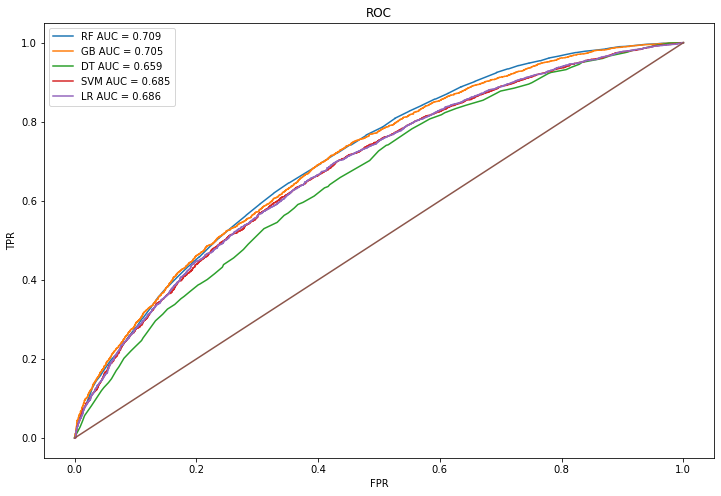

In [48]:
#Plot ROC curves of the two models

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, svm, metrics


plt.figure(figsize=(12,8))
aucs = []
labels = []

for prediction in predictions:
    fpr, tpr, thresholds = metrics.roc_curve(Y_val, predictions[prediction])
    auc = metrics.auc(fpr,tpr)
    aucs.append(auc)
    labels.append(prediction)
    label = prediction + " AUC = %.3f"%auc
    plt.plot(fpr,tpr,label = label)
    

#Plot 45 degree line
plt.plot([0,1],[0,1])

plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

plt.show()

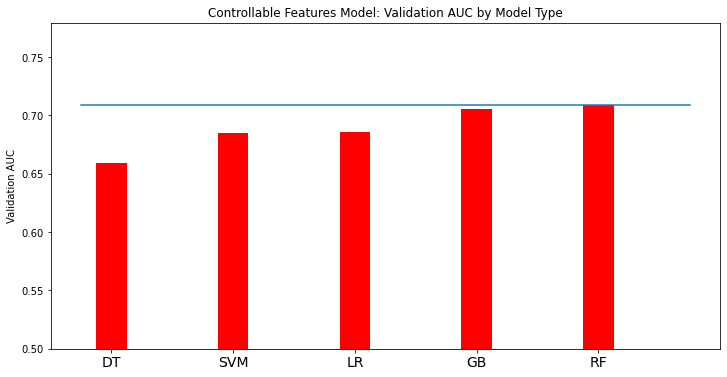

In [49]:
results = np.array(aucs)
labs = np.array(labels)[results.argsort()]
results.sort()

fig = plt.figure(facecolor = 'w', figsize = (12, 6))
ax = plt.subplot(111)

width = 0.25
ind = np.arange(5)
rec = ax.bar(ind + width, results, width, color='r')

ax.set_xticks(ind + width)
ax.set_xticklabels(labs, size = 14)
ax.set_ylim([0.5, max(results)*1.1])

plt.plot(np.arange(6), max(results) * np.ones(6))
plt.ylabel('Validation AUC')
plt.title('Controllable Features Model: Validation AUC by Model Type')
plt.show()